In [3]:
pip install ultralytics

     ---------------------------------------- 0.0/41.2 kB ? eta -:--:--
     --------- ------------------------------ 10.2/41.2 kB ? eta -:--:--
     -------------------------------------  41.0/41.2 kB 487.6 kB/s eta 0:00:01
     -------------------------------------- 41.2/41.2 kB 397.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/799.6 kB ? eta -:--:--
   - -------------------------------------- 30.7/799.6 kB ? eta -:--:--
   - ------------------------------------- 41.0/799.6 kB 653.6 kB/s eta 0:00:02
   -- ------------------------------------ 61.4/799.6 kB 825.8 kB/s eta 0:00:01
   --- ----------------------------------- 81.9/799.6 kB 573.4 kB/s eta 0:00:02
   ----- -------------------------------- 112.6/799.6 kB 547.6 kB/s eta 0:00:02
   ----- -------------------------------- 122.9/799.6 kB 481.4 kB/s eta 0:00:02
   ------ ------------------------------- 143.4/799.6 kB 502.3 kB/s eta 0:00:02
   --------- ---------------------------- 194.6/799.6 kB 562.0 kB/s eta 

In [4]:
import ultralytics
ultralytics.__version__

'8.2.51'

In [5]:
import cv2
import pandas as pd
from ultralytics import YOLO
from tracker import*

100%|██████████| 21.5M/21.5M [00:26<00:00, 838kB/s] 


In [6]:
model=YOLO('yolov8s.pt')

In [7]:
class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 
              'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [8]:
tracker=Tracker()
count=0

In [9]:
cap=cv2.VideoCapture('highway.mp4')

In [10]:
cap

< cv2.VideoCapture 0000025CAC30BDF0>

In [11]:
import os
import time

down = {}
up = {}
counter_down = []
counter_up = []

red_line_y = 198
blue_line_y = 268
offset = 6

# Create a folder to save frames
if not os.path.exists('detected_frames'):
    os.makedirs('detected_frames')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (1020, 500))

while True:
    ret, frame = cap.read()
    if not ret:
        break
    count += 1
    # if count % 2 != 0:
    #     continue
    frame = cv2.resize(frame, (1020, 500))

    results = model.predict(frame)
    a = results[0].boxes.data
    a = a.detach().cpu().numpy()
    px = pd.DataFrame(a).astype("float")
    list = []

    for index, row in px.iterrows():
        x1 = int(row[0])
        y1 = int(row[1])
        x2 = int(row[2])
        y2 = int(row[3])
        d = int(row[5])
        c = class_list[d]
        if 'car' in c:
            list.append([x1, y1, x2, y2])
    bbox_id = tracker.update(list)

    for bbox in bbox_id:
        x3, y3, x4, y4, id = bbox
        cx = int(x3 + x4) // 2
        cy = int(y3 + y4) // 2

        if red_line_y<(cy+offset) and red_line_y > (cy-offset):
           down[id]=time.time()   # current time when vehichle touch the first line
        if id in down:
          
           if blue_line_y<(cy+offset) and blue_line_y > (cy-offset):
             elapsed_time=time.time() - down[id]  # current time when vehicle touch the second line. Also we a re minusing the previous time ( current time of line 1)
             if counter_down.count(id)==0:
                counter_down.append(id)
                distance = 10 # meters 
                a_speed_ms = distance / elapsed_time
                a_speed_kh = a_speed_ms * 3.6  # this will give kilometers per hour for each vehicle. This is the condition for going downside
                cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
                cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                cv2.putText(frame,str(id),(x3,y3),cv2.FONT_HERSHEY_COMPLEX,0.6,(255,255,255),1)
                cv2.putText(frame,str(int(a_speed_kh))+'Km/h',(x4,y4 ),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)

                
        #####going UP blue line#####     
        if blue_line_y<(cy+offset) and blue_line_y > (cy-offset):
           up[id]=time.time()
        if id in up:

           if red_line_y<(cy+offset) and red_line_y > (cy-offset):
             elapsed1_time=time.time() - up[id]
             # formula of speed= distance/time 
             if counter_up.count(id)==0:
                counter_up.append(id)      
                distance1 = 10 # meters  (Distance between the 2 lines is 10 meters )
                a_speed_ms1 = distance1 / elapsed1_time
                a_speed_kh1 = a_speed_ms1 * 3.6
                cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
                cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                cv2.putText(frame,str(id),(x3,y3),cv2.FONT_HERSHEY_COMPLEX,0.6,(255,255,255),1)
                cv2.putText(frame,str(int(a_speed_kh1))+'Km/h',(x4,y4),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)



    
    text_color = (0, 0, 0)  # Black color for text
    yellow_color = (0, 255, 255)  # Yellow color for background
    red_color = (0, 0, 255)  # Red color for lines
    blue_color = (255, 0, 0)  # Blue color for lines

    cv2.rectangle(frame, (0, 0), (250, 90), yellow_color, -1)

    cv2.line(frame, (172, 198), (774, 198), red_color, 2)
    cv2.putText(frame, ('Red Line'), (172, 198), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.line(frame, (8, 268), (927, 268), blue_color, 2)
    cv2.putText(frame, ('Blue Line'), (8, 268), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.putText(frame, ('Going Down - ' + str(len(counter_down))), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    cv2.putText(frame, ('Going Up - ' + str(len(counter_up))), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    # Save frame
    frame_filename = f'detected_frames/frame_{count}.jpg'
    cv2.imwrite(frame_filename, frame)

    out.write(frame)

    cv2.imshow("frames", frame)
    if cv2.waitKey(1) & 0xFF == 27:
    #if cv2.waitKey(0) & 0xFF == 27:
        break

cap.release()
out.release()
cv2.destroyAllWindows()



0: 320x640 8 cars, 2 trucks, 1329.9ms
Speed: 113.5ms preprocess, 1329.9ms inference, 69.2ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 402.7ms
Speed: 0.0ms preprocess, 402.7ms inference, 13.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 7 cars, 2 trucks, 422.4ms
Speed: 6.8ms preprocess, 422.4ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 6 cars, 2 trucks, 333.6ms
Speed: 8.6ms preprocess, 333.6ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 354.7ms
Speed: 0.0ms preprocess, 354.7ms inference, 2.8ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 368.4ms
Speed: 4.7ms preprocess, 368.4ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 692.8ms
Speed: 3.4ms preprocess, 692.8ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 707.6ms
Spee

KeyboardInterrupt: 

#  Detecting objects and drawing 2 lines on image - red and blue

In [12]:
import cv2
import pandas as pd
from ultralytics import YOLO
from tracker import*
import time

model=YOLO('yolov8s.pt')

class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

tracker=Tracker()
count=0

cap=cv2.VideoCapture('highway_mini.mp4')


while True:    
    ret,frame = cap.read()
    if not ret:
        break
    count += 1
    frame=cv2.resize(frame,(1020,500))
   

    results=model.predict(frame)
 #   print(results)
    a=results[0].boxes.data
    a = a.detach().cpu().numpy() 
    px=pd.DataFrame(a).astype("float")
    #print(px)

    list=[]
             
    for index,row in px.iterrows():
#        print(row) 
        x1=int(row[0])
        y1=int(row[1])
        x2=int(row[2])
        y2=int(row[3])
        d=int(row[5])
        c=class_list[d]
        if 'car' in c:
            list.append([x1,y1,x2,y2])
            #print(c)

    bbox_id=tracker.update(list)
    #print(bbox_id)
    for bbox in bbox_id:
        x3,y3,x4,y4,id=bbox
        cx=int(x3+x4)//2
        cy=int(y3+y4)//2

        red_line_y=198
        blue_line_y=268   
        offset = 7

        cv2.circle(frame,(cx,cy),4,(0,0,255),-1) #draw ceter points of bounding box
        cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
        cv2.putText(frame,str(id),(cx,cy),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)
                 
    

    text_color = (255,255,255)  # white color for text
    red_color = (0, 0, 255)  # (B, G, R)   
    blue_color = (255, 0, 0)  # (B, G, R)
    green_color = (0, 255, 0)  # (B, G, R)  

    cv2.line(frame,(172,198),(774,198),red_color,3)  #  starting cordinates and end of line cordinates
    cv2.putText(frame,('red line'),(172,198),cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    
    cv2.line(frame,(8,268),(927,268),blue_color,3)  # seconde line
    cv2.putText(frame,('blue line'),(8,268),cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)    


    cv2.imshow("frames", frame)
    if cv2.waitKey(0)&0xFF==27:
        break
cap.release()
cv2.destroyAllWindows()


0: 320x640 9 cars, 3 trucks, 724.6ms
Speed: 0.0ms preprocess, 724.6ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 9 cars, 2 trucks, 447.7ms
Speed: 6.4ms preprocess, 447.7ms inference, 12.2ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 9 cars, 2 trucks, 380.4ms
Speed: 3.1ms preprocess, 380.4ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 9 cars, 2 trucks, 373.2ms
Speed: 4.1ms preprocess, 373.2ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 9 cars, 2 trucks, 395.2ms
Speed: 3.6ms preprocess, 395.2ms inference, 14.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 9 cars, 2 trucks, 320.2ms
Speed: 3.4ms preprocess, 320.2ms inference, 2.6ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 9 cars, 2 trucks, 903.0ms
Speed: 6.0ms preprocess, 903.0ms inference, 4.9ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 9 cars, 2 trucks, 541.3ms
Speed: 5

# Getting the ids of the cars those are touching red line

In [2]:
import cv2
import pandas as pd
from ultralytics import YOLO
from tracker import*
import time
from datetime import datetime

model=YOLO('yolov8s.pt')

class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

tracker=Tracker()
count=0

cap=cv2.VideoCapture('highway_mini.mp4')

down={}
up={}

counter_down=[]
counter_up=[]

while True:    
    ret,frame = cap.read()
    if not ret:
        break
    count += 1
    frame=cv2.resize(frame,(1020,500))
   

    results=model.predict(frame)
 #   print(results)
    a=results[0].boxes.data
    a = a.detach().cpu().numpy()  # added this line
    px=pd.DataFrame(a).astype("float")
    #print(px)

    list=[]
             
    for index,row in px.iterrows():
#        print(row) 
        x1=int(row[0])
        y1=int(row[1])
        x2=int(row[2])
        y2=int(row[3])
        d=int(row[5])
        c=class_list[d]
        if 'car' in c:
            list.append([x1,y1,x2,y2])
            #print(c)

    bbox_id=tracker.update(list)
    #print(bbox_id)
    for bbox in bbox_id:
        x3,y3,x4,y4,id=bbox
        cx=int(x3+x4)//2
        cy=int(y3+y4)//2

        red_line_y=198
        blue_line_y=268   
        offset = 7

        # cv2.circle(frame,(cx,cy),4,(0,0,255),-1) #draw ceter points of bounding box
        # cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
        # cv2.putText(frame,str(id),(cx,cy),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)
           
        ''' condition for red line '''
        if red_line_y < (cy + offset) and red_line_y > (cy - offset):
          ''' this if condition is putting the id and the circle on the object when the center of the object touched the red line.'''
          
          down[id]=time.time()  # current time when vehicle touch the red line

          # a = time.time()  
          # dt_object = datetime.fromtimestamp(a)
          # # Format the datetime object as a string in a readable format
          # formatted_time = dt_object.strftime("%Y-%m-%d %H:%M:%S")
          # print("Readable time:", formatted_time)
            
          #This will tell us the travelling direction of the car.
          if id in down:         
           cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
           cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box             
           cv2.putText(frame,str(id),(cx,cy),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)
    
    print("Readable time:", formatted_time)
    print(down)  # printing the id and time of the vehicle when it is touching the red line
    

    text_color = (255,255,255)  # white color for text
    red_color = (0, 0, 255)  # (B, G, R)   
    blue_color = (255, 0, 0)  # (B, G, R)
    green_color = (0, 255, 0)  # (B, G, R)  

    cv2.line(frame,(172,198),(774,198),red_color,3)  #  starting cordinates and end of line cordinates
    cv2.putText(frame,('red line'),(172,198),cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    
    cv2.line(frame,(8,268),(927,268),blue_color,3)  # seconde line
    cv2.putText(frame,('blue line'),(8,268),cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)    


    cv2.imshow("frames", frame)
    if cv2.waitKey(0)&0xFF==27:
        break
cap.release()
cv2.destroyAllWindows()


0: 320x640 9 cars, 3 trucks, 800.0ms
Speed: 4.2ms preprocess, 800.0ms inference, 7.9ms postprocess per image at shape (1, 3, 320, 640)


NameError: name 'formatted_time' is not defined

# Getting the ids of the cars those are touching red line¶

In [13]:
import cv2
import pandas as pd
from ultralytics import YOLO
from tracker import*
import time

model=YOLO('yolov8s.pt')

class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

tracker=Tracker()
count=0

cap=cv2.VideoCapture('highway_mini.mp4')

down={}
up={}

counter_down=[]
counter_up=[]

while True:    
    ret,frame = cap.read()
    if not ret:
        break
    count += 1
    frame=cv2.resize(frame,(1020,500))
   

    results=model.predict(frame)
 #   print(results)
    a=results[0].boxes.data
    a = a.detach().cpu().numpy()  # added this line
    px=pd.DataFrame(a).astype("float")
    #print(px)

    list=[]
             
    for index,row in px.iterrows():
#        print(row) 
        x1=int(row[0])
        y1=int(row[1])
        x2=int(row[2])
        y2=int(row[3])
        d=int(row[5])
        c=class_list[d]
        if 'car' in c:
            list.append([x1,y1,x2,y2])
            #print(c)

    bbox_id=tracker.update(list)
    #print(bbox_id)
    for bbox in bbox_id:
        x3,y3,x4,y4,id=bbox
        cx=int(x3+x4)//2
        cy=int(y3+y4)//2

        red_line_y=198
        blue_line_y=268   
        offset = 7

        # cv2.circle(frame,(cx,cy),4,(0,0,255),-1) #draw ceter points of bounding box
        # cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
        # cv2.putText(frame,str(id),(cx,cy),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)
           
    #     ''' condition for red line '''
    #     if red_line_y < (cy + offset) and red_line_y > (cy - offset):
    #       ''' this if condition is putting the id and the circle on the object when the center of the object touched the red line.'''
          
    #       down[id]=time.time()  # current time when vehicle touch the red line
    #       #This will tell us the travelling direction of the car.
    #       if id in down:         
    #        cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
    #        cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box             
    #        cv2.putText(frame,str(id),(cx,cy),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)

    #print(down)  # printing the id and time of the vehicle when it is touching the red line
    

        ''' condition for blue line '''

        if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
          up[id]=time.time()   ## current time when vehicle touch the blue line
          if id in up:         
           cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
           cv2.putText(frame,str(id),(cx,cy),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)        
           counter_up.append(id)        

    print(up)  # printing the id and time of the vehicle when it is touching the red line

    
    text_color = (255,255,255)  # white color for text
    red_color = (0, 0, 255)  # (B, G, R)   
    blue_color = (255, 0, 0)  # (B, G, R)
    green_color = (0, 255, 0)  # (B, G, R)  

    cv2.line(frame,(172,198),(774,198),red_color,3)  #  starting cordinates and end of line cordinates
    cv2.putText(frame,('red line'),(172,198),cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    
    cv2.line(frame,(8,268),(927,268),blue_color,3)  # seconde line
    cv2.putText(frame,('blue line'),(8,268),cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)    


    cv2.imshow("frames", frame)
    if cv2.waitKey(0)&0xFF==27:
        break
cap.release()
cv2.destroyAllWindows()


0: 320x640 9 cars, 3 trucks, 22.0ms
Speed: 0.0ms preprocess, 22.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


{}



0: 320x640 9 cars, 2 trucks, 47.0ms
Speed: 1.0ms preprocess, 47.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)



{}


0: 320x640 9 cars, 2 trucks, 52.1ms
Speed: 1.0ms preprocess, 52.1ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)


{}



0: 320x640 9 cars, 2 trucks, 332.6ms
Speed: 2.0ms preprocess, 332.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)



{}


0: 320x640 9 cars, 2 trucks, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



{}


0: 320x640 9 cars, 2 trucks, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



{}


0: 320x640 9 cars, 2 trucks, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 320x640 9 cars, 2 trucks, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


{}
{}



0: 320x640 9 cars, 2 trucks, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


{}



0: 320x640 9 cars, 2 trucks, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


{}



0: 320x640 9 cars, 2 trucks, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



{}


0: 320x640 9 cars, 2 trucks, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 320x640 9 cars, 2 trucks, 7.0ms


{}


Speed: 0.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


{}



0: 320x640 9 cars, 2 trucks, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


{}



0: 320x640 9 cars, 2 trucks, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


{}



0: 320x640 9 cars, 2 trucks, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


{}



0: 320x640 9 cars, 2 trucks, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



{}


0: 320x640 8 cars, 2 trucks, 14.0ms
Speed: 0.0ms preprocess, 14.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


{}



0: 320x640 8 cars, 3 trucks, 69.0ms
Speed: 3.0ms preprocess, 69.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


{}



0: 320x640 8 cars, 2 trucks, 116.7ms
Speed: 1.0ms preprocess, 116.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


{}



0: 320x640 8 cars, 2 trucks, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


{}



0: 320x640 9 cars, 2 trucks, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


{}



0: 320x640 8 cars, 2 trucks, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


{}



0: 320x640 9 cars, 2 trucks, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


{}



0: 320x640 9 cars, 2 trucks, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 320x640 10 cars, 2 trucks, 6.0ms


{}


Speed: 1.0ms preprocess, 6.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


{}



0: 320x640 10 cars, 2 trucks, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


{}



0: 320x640 10 cars, 2 trucks, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 320x640 10 cars, 2 trucks, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


{}
{}



0: 320x640 9 cars, 2 trucks, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 320x640 9 cars, 2 trucks, 6.0ms


{0: 1708254627.1850293}


Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


{0: 1708254627.3692145}



0: 320x640 9 cars, 2 trucks, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


{0: 1708254627.5747154}



0: 320x640 8 cars, 3 trucks, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


{0: 1708254627.5747154}



0: 320x640 8 cars, 2 trucks, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


{0: 1708254627.5747154}



0: 320x640 9 cars, 2 trucks, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


{0: 1708254627.5747154}



0: 320x640 9 cars, 2 trucks, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 320x640 9 cars, 2 trucks, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


{0: 1708254627.5747154}
{0: 1708254627.5747154}



0: 320x640 9 cars, 2 trucks, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 320x640 10 cars, 2 trucks, 17.1ms
Speed: 1.0ms preprocess, 17.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


{0: 1708254627.5747154}
{0: 1708254627.5747154}



0: 320x640 9 cars, 2 trucks, 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 320x640 10 cars, 2 trucks, 17.0ms


{0: 1708254627.5747154}


Speed: 2.0ms preprocess, 17.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 320x640 10 cars, 2 trucks, 15.0ms


{0: 1708254627.5747154}


Speed: 1.0ms preprocess, 15.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 320x640 8 cars, 2 trucks, 18.0ms


{0: 1708254627.5747154}


Speed: 1.0ms preprocess, 18.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 320x640 9 cars, 1 truck, 17.8ms


{0: 1708254627.5747154, 4: 1708254629.9271524}


Speed: 1.0ms preprocess, 17.8ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 320x640 10 cars, 3 trucks, 15.0ms


{0: 1708254627.5747154, 4: 1708254630.135394}


Speed: 1.0ms preprocess, 15.0ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)


{0: 1708254627.5747154, 4: 1708254630.135394}



0: 320x640 9 cars, 2 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


{0: 1708254627.5747154, 4: 1708254630.135394}



0: 320x640 9 cars, 2 trucks, 194.9ms
Speed: 1.0ms preprocess, 194.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


{0: 1708254627.5747154, 4: 1708254630.135394}


# Final Code
##### how to calculate speed?

We will use the speed formula which is 
#### speed= distance/time  (distance travelled and elapsed time) 
Elapsed time is the duration between the starting point and the ending point of the movement.

distance = 10 # meters :- distance between the 2 lines(red and blue line) is 10 meters
a_speed_ms = distance / elapsed_time   # ms is meter per second.
We can apply this formula because we have distance and elapsed time.

a_speed_kh = a_speed_ms * 3.6  # this will give kilometers per hour for each vehicle. This is the condition for going downside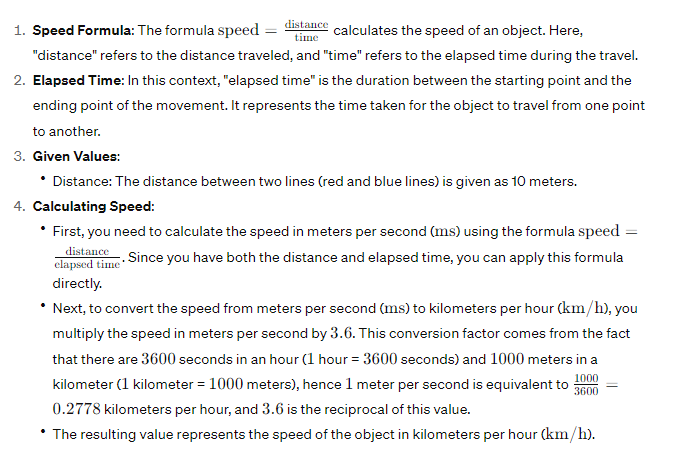

In [3]:
import cv2
import os
import pandas as pd
from ultralytics import YOLO
from tracker import Tracker

model = YOLO('yolov8s.pt')

cap = cv2.VideoCapture('highway.mp4')
#cap = cv2.VideoCapture('highway_mini.mp4')

class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

count = 0
tracker = Tracker()
down = {}
up = {}
counter_down = []
counter_up = []

red_line_y = 198
blue_line_y = 268
offset = 6

# Create a folder to save frames
if not os.path.exists('detected_frames'):
    os.makedirs('detected_frames')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (1020, 500))

while True:
    ret, frame = cap.read()
    if not ret:
        break
    count += 1
    # if count % 2 != 0:
    #     continue
    frame = cv2.resize(frame, (1020, 500))

    results = model.predict(frame)
    a = results[0].boxes.data
    a = a.detach().cpu().numpy()
    px = pd.DataFrame(a).astype("float")
    list = []

    for index, row in px.iterrows():
        x1 = int(row[0])
        y1 = int(row[1])
        x2 = int(row[2])
        y2 = int(row[3])
        d = int(row[5])
        c = class_list[d]
        if 'car' in c:
            list.append([x1, y1, x2, y2])
    bbox_id = tracker.update(list)

    for bbox in bbox_id:
        x3, y3, x4, y4, id = bbox
        cx = int(x3 + x4) // 2
        cy = int(y3 + y4) // 2

        # if red_line_y < (cy + offset) and red_line_y > (cy - offset):
        #     down[id] = cy
        # if id in down:
        #     if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
        #         cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
        #         cv2.putText(frame, str(id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)
        #         counter_down.add(id)  # Add ID to set

        # if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
        #     up[id] = cy
        # if id in up:
        #     if red_line_y < (cy + offset) and red_line_y > (cy - offset):
        #         cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
        #         cv2.putText(frame, str(id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)
        #         counter_up.add(id)  # Add ID to set


        if red_line_y<(cy+offset) and red_line_y > (cy-offset):
           down[id]=time.time()   # current time when vehichle touch the first line
        if id in down:
          
           if blue_line_y<(cy+offset) and blue_line_y > (cy-offset):
             elapsed_time=time.time() - down[id]  # current time when vehicle touch the second line. Also we a re minusing the previous time ( current time of line 1)
             if counter_down.count(id)==0:
                counter_down.append(id)
                distance = 10 # meters - distance between the 2 lines is 10 meters
                a_speed_ms = distance / elapsed_time
                a_speed_kh = a_speed_ms * 3.6  # this will give kilometers per hour for each vehicle. This is the condition for going downside
                cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
                cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                cv2.putText(frame,str(id),(x3,y3),cv2.FONT_HERSHEY_COMPLEX,0.6,(255,255,255),1)
                cv2.putText(frame,str(int(a_speed_kh))+'Km/h',(x4,y4 ),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)

                
        #####going UP#####     
        if blue_line_y<(cy+offset) and blue_line_y > (cy-offset):
           up[id]=time.time()
        if id in up:

           if red_line_y<(cy+offset) and red_line_y > (cy-offset):
             elapsed1_time=time.time() - up[id]
             # formula of speed= distance/time  (distance travelled and elapsed time) Elapsed time is It represents the duration between the starting point and the ending point of the movement.
             if counter_up.count(id)==0:
                counter_up.append(id)      
                distance1 = 10 # meters  (Distance between the 2 lines is 10 meters )
                a_speed_ms1 = distance1 / elapsed1_time
                a_speed_kh1 = a_speed_ms1 * 3.6
                cv2.circle(frame,(cx,cy),4,(0,0,255),-1)
                cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                cv2.putText(frame,str(id),(x3,y3),cv2.FONT_HERSHEY_COMPLEX,0.6,(255,255,255),1)
                cv2.putText(frame,str(int(a_speed_kh1))+'Km/h',(x4,y4),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,255,255),2)



    
    text_color = (0, 0, 0)  # Black color for text
    yellow_color = (0, 255, 255)  # Yellow color for background
    red_color = (0, 0, 255)  # Red color for lines
    blue_color = (255, 0, 0)  # Blue color for lines

    cv2.rectangle(frame, (0, 0), (250, 90), yellow_color, -1)

    cv2.line(frame, (172, 198), (774, 198), red_color, 2)
    cv2.putText(frame, ('Red Line'), (172, 198), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.line(frame, (8, 268), (927, 268), blue_color, 2)
    cv2.putText(frame, ('Blue Line'), (8, 268), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.putText(frame, ('Going Down - ' + str(len(counter_down))), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    cv2.putText(frame, ('Going Up - ' + str(len(counter_up))), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    # Save frame
    frame_filename = f'detected_frames/frame_{count}.jpg'
    cv2.imwrite(frame_filename, frame)

    out.write(frame)

    cv2.imshow("frames", frame)
    if cv2.waitKey(1) & 0xFF == 27:
    #if cv2.waitKey(0) & 0xFF == 27:
        break

cap.release()
out.release()
cv2.destroyAllWindows()



0: 320x640 8 cars, 2 trucks, 599.6ms
Speed: 12.5ms preprocess, 599.6ms inference, 7.8ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 566.7ms
Speed: 3.0ms preprocess, 566.7ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 7 cars, 2 trucks, 653.5ms
Speed: 16.8ms preprocess, 653.5ms inference, 9.9ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 6 cars, 2 trucks, 619.2ms
Speed: 6.6ms preprocess, 619.2ms inference, 10.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 741.8ms
Speed: 3.1ms preprocess, 741.8ms inference, 5.2ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 809.5ms
Speed: 9.2ms preprocess, 809.5ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 689.5ms
Speed: 5.2ms preprocess, 689.5ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 8 cars, 2 trucks, 572.1ms
Speed: 

KeyboardInterrupt: 